In [1]:
import gc

gc.enable()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

import lightgbm as lgb

import os
import os.path
# print(os.listdir("../input"))

# credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
random_seed = 15305
df_train = None

if not os.path.isfile('train_V2_solo.csv'):
    print('Solo file not exists, load all')
    df_train = pd.read_csv('train_V2.csv')
    df_train = reduce_mem_usage(df_train)
    df_train = df_train[df_train['winPlacePerc'].isna() != True]
    mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
    
    df_train['matchType'].value_counts().plot.bar()
    
    df_train['matchType'] = df_train['matchType'].apply(mapper)
    
    old_size = df_train.shape[0]
    
    df_train = df_train[df_train['matchType'] == 'solo']
    
    print('Reduced size from ', old_size, ' to ', df_train.shape[0])
    
    df_train.to_csv('train_V2_solo.csv', index=False)
    
else:
    df_train = pd.read_csv('train_V2_solo.csv')
    df_train = reduce_mem_usage(df_train)
    print('Solo file exists, loaded, size: ', df_train.shape[0])
        

gc.collect()

Solo file exists, loaded, size:  720712


7

In [3]:
df_train.describe(include=np.number).drop('count').T

,mean,std,min,25%,50%,75%,max
assists,0.062236,0.297540,0.0,0.000000,0.000000,0.000000,22.0
boosts,1.059862,1.799456,0.0,0.000000,0.000000,2.000000,28.0
damageDealt,NaN,NaN,0.0,0.000000,74.375000,169.250000,6616.0
DBNOs,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
headshotKills,0.249281,0.660425,0.0,0.000000,0.000000,0.000000,42.0
heals,1.014149,2.406086,0.0,0.000000,0.000000,1.000000,63.0
killPlace,47.457529,27.728956,1.0,23.000000,47.000000,71.000000,100.0
killPoints,447.426431,594.989089,0.0,0.000000,0.000000,1090.000000,1970.0
kills,0.936860,1.603249,0.0,0.000000,0.000000,1.000000,66.0
killStreaks,0.475054,0.564241,0.0,0.000000,0.000000,1.000000,18.0


<!--df_train.drop('DBNOs',  axis =1,inplace= True)
df_train.drop('revives',  axis =1,inplace= True) !-->

In [4]:
df_train['maxPlace'].describe()

count    720712.000000
mean         93.908900
std          10.134818
min           2.000000
25%          94.000000
50%          96.000000
75%          97.000000
max         100.000000
Name: maxPlace, dtype: float64

In [5]:
# from sklearn.preprocessing import MinMaxScaler

def feature_engineering(df, is_train=True):
    test_idx = None
    if not is_train: 
        print("processing test")
        test_idx = df.Id
    else:
        print("processing train")
    

    
    print("remove some columns")
    target = 'winPlacePerc'
    
    by_team = ['matchId','groupId']

    print("Adding Features")
    
    df['headshotrate'] = df['kills']/df['headshotKills']
#     df['killStreakrate'] = df['killStreaks']/df['kills']
    df['healthitems'] = df['heals'] + df['boosts']
    df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
    df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
    df['distance_over_weapons'] = df['totalDistance'] / df['weaponsAcquired']
    
#     df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
    
#     df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
    
#     df['killsPerWalkDistance'] = df['kills'] / df['walkDistance']
    
    df['skill'] = df['headshotKills'] + df['roadKills']
    
#     df['totalTimeByDistance'] = df['rideDistance'] / float(5) + df['walkDistance'] + df['swimDistance'] * float(5)
    
#     df['zombi'] = ((df['totalDistance'] == 0) & (df['kills'] == 0)
#                      & (df['weaponsAcquired'] == 0)).astype(int)
#     df['cheater'] = ((df['kills'] / df['totalDistance'] >= 1)
#                        | (df['kills'] > 30) | (df['roadKills'] > 10)).astype(int)

    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    
    print("Removing Na's From DF")
    df.fillna(0, inplace=True)

    
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    features.remove("matchType")
    
    
      
    y = None
    
    
    if is_train: 
        print("get target")
        y = np.array(df.groupby(by_team)[target].agg('mean'), dtype=np.float64)
        features.remove(target)

    print("get group mean feature")
    agg = df.groupby(by_team)[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    if is_train: df_out = agg.reset_index()[by_team]
    else: df_out = df[by_team]
    
    
    

    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=by_team)
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=by_team)

    
    
    # Важные фичы, поскольку оказывается группа может быть больше 1, хотя соло
    
#     print("get group sum feature")
#     agg = df.groupby(by_team)[features].agg('sum')
#     agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
#     df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=by_team)
#     df_out = df_out.merge(agg_rank, suffixes=["_sum", "_sum_rank"], how='left', on=by_team)
    
    print("get group max feature")
    agg = df.groupby(by_team)[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=by_team)
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=by_team)
    
    print("get group min feature")
    agg = df.groupby(by_team)[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=by_team)
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=by_team)
    
    
    print("get group size feature")
    agg = df.groupby(by_team).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=by_team)
    
    print("get match mean feature")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])
    
    
    print("get match size feature")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(by_team, axis=1, inplace=True)

#     scaler = MinMaxScaler()
#     scaler.fit(df_out)
    X = df_out #scaler.transform(df_out)
    
    feature_names = list(df_out.columns)

    del df, df_out, agg, agg_rank
    gc.collect()

    return X, y, feature_names, test_idx

In [6]:
X, y, columns, _ = feature_engineering(df_train, True)
X = reduce_mem_usage(X)

processing train
remove some columns
Adding Features
Removing Na's From DF
get target
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature


In [7]:
X[X['group_size'] > 1].describe()

,assists_mean,boosts_mean,damageDealt_mean,DBNOs_mean,headshotKills_mean,heals_mean,killPlace_mean,killPoints_mean,kills_mean,killStreaks_mean,...,weaponsAcquired,winPoints,headshotrate,healthitems,totalDistance,killPlace_over_maxPlace,headshotKills_over_kills,distance_over_weapons,skill,match_size
count,17404.000000,17404.000000,1.740400e+04,17404.0,17404.000000,17404.000000,1.740400e+04,1.740400e+04,17404.000000,17404.000000,...,1.740400e+04,1.740400e+04,17404.000000,17404.000000,1.740400e+04,17404.000000,17404.000000,1.740400e+04,17404.000000,17404.000000
mean,0.066895,0.283203,inf,0.0,0.128418,0.378662,inf,inf,0.505859,0.242920,...,inf,inf,0.419678,2.093750,inf,0.508301,0.109558,inf,0.289062,90.235348
std,0.434326,0.651367,inf,0.0,0.567383,1.135742,2.728125e+01,inf,1.730469,0.419922,...,3.062500e+00,inf,0.496582,0.702148,inf,0.020279,0.042023,inf,0.403076,18.747609
min,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,1.500000e+00,0.000000e+00,0.000000,0.000000,...,1.937500e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.504883,0.000000,0.000000e+00,0.000000,6.000000
25%,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,...,3.228516e+00,0.000000e+00,0.316406,1.745117,8.880000e+02,0.505371,0.090088,2.301250e+02,0.212769,93.000000
50%,0.000000,0.000000,2.228906e+01,0.0,0.000000,0.000000,6.700000e+01,0.000000e+00,0.000000,0.000000,...,3.660156e+00,0.000000e+00,0.371582,2.074219,1.134500e+03,0.505371,0.109375,3.005000e+02,0.247437,95.000000
75%,0.000000,0.235535,7.545312e+01,0.0,0.000000,0.000000,9.150000e+01,1.080000e+03,0.500000,0.500000,...,4.066406e+00,1.505000e+03,0.425049,2.458984,2.198000e+03,0.505371,0.129028,4.755000e+02,0.284180,97.000000
max,10.000000,7.000000,3.676000e+03,0.0,27.500000,21.500000,9.950000e+01,1.720000e+03,37.500000,6.500000,...,6.600000e+01,1.541000e+03,7.515625,11.453125,5.148000e+03,0.899902,0.532227,1.317000e+03,7.125000,100.000000


In [8]:
X[~(X['group_size'] > 1)].describe()

,assists_mean,boosts_mean,damageDealt_mean,DBNOs_mean,headshotKills_mean,heals_mean,killPlace_mean,killPoints_mean,kills_mean,killStreaks_mean,...,weaponsAcquired,winPoints,headshotrate,healthitems,totalDistance,killPlace_over_maxPlace,headshotKills_over_kills,distance_over_weapons,skill,match_size
count,676089.0,676089.0,676089.00,676089.0,676089.0,676089.0,676089.0,676089.0,676089.0,676089.0,...,676089.000000,676089.0,676089.000000,676089.000000,676089.0,676089.000000,676089.000000,676089.000,676089.000000,676089.000000
mean,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.806188
std,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,5.967268
min,0.0,0.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.500000,0.0,0.000000,0.000000,0.0,0.500000,0.000000,0.000,0.000000,2.000000
25%,0.0,0.0,0.00,0.0,0.0,0.0,23.0,0.0,0.0,0.0,...,3.164062,0.0,0.329590,1.739258,880.0,0.505371,0.093811,229.375,0.218750,94.000000
50%,0.0,0.0,79.75,0.0,0.0,0.0,46.0,0.0,0.0,0.0,...,3.437500,0.0,0.380615,2.031250,1001.5,0.505371,0.111389,266.750,0.250000,96.000000
75%,0.0,2.0,175.00,0.0,0.0,1.0,70.0,1098.0,1.0,1.0,...,3.927734,1506.0,0.430176,2.380859,2064.0,0.505371,0.130371,448.500,0.284180,97.000000
max,22.0,28.0,6616.00,0.0,42.0,63.0,100.0,1970.0,65.0,18.0,...,79.750000,1541.0,7.515625,11.453125,5148.0,0.899902,0.532227,1317.000,7.183594,100.000000


In [9]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.1,
random_state=random_seed)

In [10]:
print(X_train.shape, X_holdout.shape)

(624143, 219) (69350, 219)


In [11]:
train_index = round(int(X_train.shape[0]*0.7))
dev_X = X_train[:train_index] 
val_X = X_train[train_index:]
dev_y = y_train[:train_index] 
val_y = y_train[train_index:] 
gc.collect()


model_name = 'model_best.txt'

def run_lgb(train_X, train_y, val_X, val_y, x_test):
    params = {"objective" : "regression", "metric" : "mae", 'n_estimators':5000, 'early_stopping_rounds':200,
              "num_leaves" : 31, "learning_rate" : 0.05, "bagging_fraction" : 0.5,
               "bagging_seed" : 0, "num_threads" : 4,"colsample_bytree" : 0.5
             }

    model = None
    
    if not os.path.isfile(model_name):
        print(model_name, ' not found, start train ;-(')
        lgtrain = lgb.Dataset(train_X, label=train_y)
        lgval = lgb.Dataset(val_X, label=val_y)
        model = lgb.train(params, lgtrain, valid_sets=[lgtrain, lgval], verbose_eval=1000)
        model.save_model(model_name)
        
    else:
        print(model_name, ' found, start predict ;-)')
        model = lgb.Booster(model_file=model_name)
        
    
    pred_test_y = model.predict(x_test, num_iteration=model.best_iteration)
    return pred_test_y, model

# Training the model #
pred_test, model = run_lgb(dev_X, dev_y, val_X, val_y, X_holdout)
gc.collect()

model_best.txt  found, start predict ;-)


7

In [12]:
pred_y = pred_test.copy()
df_sub = X_holdout.copy()
gc.collect()

0

In [72]:
print("MAE: ",
mean_absolute_error(y_holdout, pred_y) )

print("EVS: ",
explained_variance_score(y_holdout, pred_y))

MAE:  0.029899288500510764
EVS:  0.9786677100938388


<!--df_sub['winPlacePerc'] = pred_test
df_sub.loc[df_sub.maxPlace == 0, "winPlacePerc"] = 0
df_sub.loc[df_sub.maxPlace == 1, "winPlacePerc"] = 1

print("MAE: ",
mean_absolute_error(y_holdout, df_sub["winPlacePerc"]) )

print("EVS: ",
explained_variance_score(y_holdout, df_sub["winPlacePerc"]))

df_sub.loc[(df_sub['maxPlace'] > 1) & (df_sub['numGroups'] == 1), 'winPlacePerc'] = 0

print("MAE: ",
mean_absolute_error(y_holdout, df_sub["winPlacePerc"]) )

print("EVS: ",
explained_variance_score(y_holdout, df_sub["winPlacePerc"]))


subset = df_sub.loc[df_sub.maxPlace > 1]
gap = 1.0 / (subset.maxPlace.values - 1)
new_perc = np.around(subset.winPlacePerc.values / gap) * gap
df_sub.loc[df_sub.maxPlace > 1, "winPlacePerc"] = new_perc

print("MAE: ",
mean_absolute_error(y_holdout, df_sub["winPlacePerc"]) )

print("EVS: ",
explained_variance_score(y_holdout, df_sub["winPlacePerc"])) !-->


<!--model_starter_pack.txt <br>
MAE:  0.02558280060335631 <br>
EVS:  0.9829401785773265 <br>
MAE:  0.025582453320029258 <br>
EVS:  0.9829402359549503 <br>
MAE:  0.0253387907725405 <br>
EVS:  0.9828247008305454 !-->

<!--model_starter_pack_with_zg_out_dr.txt <br>
MAE:  0.025545057079930968 <br> 
EVS:  0.9829855181118134 <br>
MAE:  0.025544790745056885 <br>
EVS:  0.9829855473042595 <br>
MAE:  0.02531235797334766 <br>
EVS:  0.9828720094152441 !-->

<!--(0.0253387907725405 - 0.02531235797334766)!-->

<!--MAE:  0.028207526864759577
EVS:  0.9806129002783865
    
MAE:  0.027302055138423157
EVS:  0.9815539895968597
MAE:  0.02724490554611779
EVS:  0.9815991400817509 !-->

In [73]:
fi = model.feature_importance()
fn = model.feature_name()


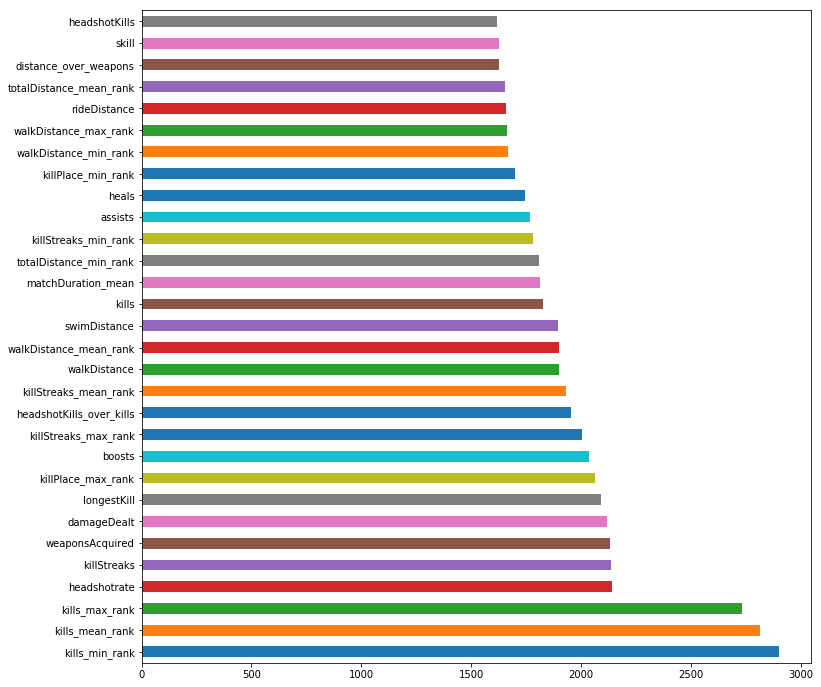

In [74]:
feat_importances = pd.Series(fi, index=fn)
feat_importances.nlargest(30).plot(kind='barh', figsize=(12,12))

<!--model_without_DBNOs_revives.txt <br>
MAE:  0.02577354713900555 <br>
EVS:  0.9827448813735692 <br>!-->

<!--model_with_zombi_cheaters.txt <br>
MAE:  0.025709583594034434 <br>
EVS:  0.9828208981885771 <br>!-->